# **Modelo Final - Detector de Dados Pessoais**

**Desafio Participa DF - Categoria Acesso à Informação**

**Objetivo:** Identificar automaticamente, entre os pedidos de acesso à informação marcados como públicos, aqueles que contenham dados pessoais e que, portanto, deveriam ser classificados como não públicos.

**Dados pessoais considerados:** Nome, CPF, RG, telefone, e-mail e outros identificadores diretos ou indiretos de pessoa natural.

**Abordagem:** Solução híbrida combinando **Expressões Regulares** (**Regex**) para padrões estruturados e **Processamento de Linguagem Natural (NLP) com spaCy para detecção de nomes de pessoas.

**Autor:** Lucas Boros

**Data:** Janeiro/2026

## `Importação das Bibliotecas`

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np
import re

# NLP
import spacy

# Visualização
import matplotlib.pyplot as plt

# Métricas de avaliação
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Configurações
import warnings
warnings.filterwarnings('ignore')

# Carregar modelo spaCy para português
nlp = spacy.load('pt_core_news_sm')

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## `Carregamento dos Dados`

In [2]:
# Carregar o dataset
df = pd.read_excel('AMOSTRA_e-SIC.xlsx')

# Informações básicas
print("=== DATASET CARREGADO ===")
print(f"Registros: {df.shape[0]}")
print(f"Colunas: {list(df.columns)}")
print(f"Valores nulos: {df.isnull().sum().sum()}")
print(f"Duplicatas: {df.duplicated().sum()}")

df.head()

=== DATASET CARREGADO ===
Registros: 99
Colunas: ['ID', 'Texto Mascarado']
Valores nulos: 0
Duplicatas: 0


,ID,Texto Mascarado
0,1,Solicito cópia do cadastro que preenchi virtua...
1,2,Gostaria de saber da defensoria se q irão impl...
2,3,Oi estou chateada o meu companheiro está estra...
3,4,"Prezados senhores, boa tarde!\n\nSolicito aces..."
4,5,Solicito acesso a um laudo de adicional de per...


## `Análise Exploratória` -- **Resumida**

In [3]:
# Estatísticas do texto
df['tamanho_texto'] = df['Texto Mascarado'].apply(len)
df['qtd_palavras'] = df['Texto Mascarado'].apply(lambda x: len(str(x).split()))

print("=== ESTATÍSTICAS DO TEXTO ===")
print(f"Tamanho médio: {df['tamanho_texto'].mean():.0f} caracteres")
print(f"Quantidade média de palavras: {df['qtd_palavras'].mean():.0f}")
print(f"Menor texto: {df['tamanho_texto'].min()} caracteres")
print(f"Maior texto: {df['tamanho_texto'].max()} caracteres")

=== ESTATÍSTICAS DO TEXTO ===
Tamanho médio: 507 caracteres
Quantidade média de palavras: 77
Menor texto: 10 caracteres
Maior texto: 3229 caracteres


# `Modelo de Detecção de Dados Pessoais`

## ***Definição do Modelo***:

#### Abordagem Híbrida:
1. **Regex:** Detecta padrões estruturados (CPF, e-mail, telefone, matrícula, OAB, CNPJ)
2. **NLP (spaCy):** Detecta nomes de pessoas através de Reconhecimento de Entidades Nomeadas (NER)

In [ ]:
# ========================
# CONFIGURAÇÃO DO MODELO
# =========================

# Lista de falsos positivos para filtrar na detecção de nomes
FALSOS_POSITIVOS = [
    # Órgãos e empresas
    'caesb', 'detran', 'tcb', 'der', 'seduh', 'seec', 'pmdf', 'cbmdf', 
    'sicoob', 'terracap', 'adasa', 'cgdf', 'gdf', 'setor público',
    'sociedade de transportes coletivos de brasília', 'controladora-geral', 'distrito federal',
    # Tratamentos e saudações
    'vossa senhoria', 'vossas senhorias', 'excelência', 'encaminho',
    'certidão', 'ônus', 'atenciosamente', 'cordialmente', 'prezados',
    'prezado', 'prezada', 'ilustríssimo', 'ilustrissimo',
    # Termos técnicos/jurídicos
    'gestão de integridade', 'gestão de', 'governança de tic',
    'administração de banco de dados', 'letramento digital',
    'superior a15', 'inciso xxxiii', 'inciso ii', 'inciso xv',
    'advogados associados', 'setor público',
    'lei maria da penha', 'moro de aluguel',
    # Termos químicos/técnicos
    'coliformes termotolerantes', 'fósforo total', 'nitrogênio amoniacal',
    'nitrogênio total', 'oxigênio dissolvido', 'sólidos totais', 'letramento digital'
]

# Palavras que indicam que a entidade não é uma pessoa
PALAVRAS_INVALIDAS = [
    'ltda', 'associados', 'advogados', 'inciso', 'gestão', 'administração', 
    'setor', 'lei', 'sociedade', 'coliformes', 'fósforo', 'nitrogênio',
    'oxigênio', 'sólidos', 'moro'
]

# Padrões regex para dados pessoais estruturados
PADROES_REGEX = {
    'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
    'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
    'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
    'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
    'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
    'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
}

print("Configuração do modelo carregada!")
print(f"- {len(PADROES_REGEX)} padrões regex")
print(f"- {len(FALSOS_POSITIVOS)} falsos positivos filtrados")
print(f"- {len(PALAVRAS_INVALIDAS)} palavras inválidas filtradas")

Configuração do modelo carregada!
- 6 padrões regex
- 50 falsos positivos filtrados
- 15 palavras inválidas filtradas


In [5]:
# ============================================
# FUNÇÕES DO MODELO
# ============================================

def detectar_nomes_pessoas(texto):
    """
    Detecta nomes de pessoas usando NLP (spaCy).
    Filtra falsos positivos e entidades inválidas.
    
    Args:
        texto: String com o texto a ser analisado
        
    Returns:
        Lista de nomes de pessoas detectados
    """
    doc = nlp(str(texto))
    nomes = []
    
    for ent in doc.ents:
        if ent.label_ == 'PER':
            nome_lower = ent.text.lower().strip()
            
            # Filtros
            eh_falso_positivo = any(fp in nome_lower for fp in FALSOS_POSITIVOS)
            tem_tamanho_minimo = len(ent.text.split()) >= 2
            contem_palavra_invalida = any(p in nome_lower for p in PALAVRAS_INVALIDAS)
            
            if not eh_falso_positivo and tem_tamanho_minimo and not contem_palavra_invalida:
                nomes.append(ent.text)
    
    return nomes


def detectar_padroes_regex(texto):
    """
    Detecta dados pessoais estruturados usando expressões regulares.
    
    Args:
        texto: String com o texto a ser analisado
        
    Returns:
        Dicionário com os padrões encontrados
    """
    texto = str(texto)
    encontrados = {}
    
    for nome, padrao in PADROES_REGEX.items():
        matches = re.findall(padrao, texto)
        if matches:
            encontrados[nome] = matches
    
    return encontrados


def classificar_texto(texto):
    """
    Classifica um texto quanto à presença de dados pessoais.
    
    Args:
        texto: String com o texto a ser analisado
        
    Returns:
        1 se contém dados pessoais (Não Público)
        0 se não contém dados pessoais (Público)
    """
    texto = str(texto)
    
    # Verifica padrões estruturados (regex)
    for padrao in PADROES_REGEX.values():
        if re.search(padrao, texto):
            return 1
    
    # Verifica nomes de pessoas (NLP)
    if len(detectar_nomes_pessoas(texto)) > 0:
        return 1
    
    return 0


def classificar_dataset(dataframe, coluna_texto='Texto Mascarado', coluna_id='ID'):
    """
    Classifica todos os textos de um DataFrame.
    
    Args:
        dataframe: DataFrame com os textos
        coluna_texto: Nome da coluna com os textos
        coluna_id: Nome da coluna com os IDs
        
    Returns:
        DataFrame com as colunas ID e Classificacao
    """
    resultado = pd.DataFrame()
    resultado[coluna_id] = dataframe[coluna_id]
    resultado['Classificacao'] = dataframe[coluna_texto].apply(classificar_texto)
    
    return resultado


print("Funções do modelo definidas!")

Funções do modelo definidas!


## ***Aplicação do Modelo***

In [6]:
# Aplicar modelo ao dataset
df['Classificacao'] = df['Texto Mascarado'].apply(classificar_texto)

# Resultado
print("=== RESULTADO DA CLASSIFICAÇÃO ===\n")
print(df['Classificacao'].value_counts())

total = len(df)
publicos = (df['Classificacao'] == 0).sum()
nao_publicos = (df['Classificacao'] == 1).sum()

print(f"\n- Público (sem dados pessoais): {publicos} ({publicos/total:.1%})")
print(f"- Não Público (com dados pessoais): {nao_publicos} ({nao_publicos/total:.1%})")

=== RESULTADO DA CLASSIFICAÇÃO ===

Classificacao
0    62
1    37
Name: count, dtype: int64

- Público (sem dados pessoais): 62 (62.6%)
- Não Público (com dados pessoais): 37 (37.4%)


## `Detalhamemto dos Dados Pessoais Detectados`

In [7]:
# Mostrar detalhes dos textos classificados como Não Público
print("=== DETALHAMENTO DOS TEXTOS COM DADOS PESSOAIS ===\n")

textos_nao_publicos = df[df['Classificacao'] == 1]

for i, row in textos_nao_publicos.head(10).iterrows():
    texto = row['Texto Mascarado']
    
    # Detectar o que foi encontrado
    padroes = detectar_padroes_regex(texto)
    nomes = detectar_nomes_pessoas(texto)
    
    print(f"ID {row['ID']}:")
    if padroes:
        for tipo, valores in padroes.items():
            print(f"  - {tipo}: {valores}")
    if nomes:
        print(f"  - Nomes: {nomes}")
    print()

=== DETALHAMENTO DOS TEXTOS COM DADOS PESSOAIS ===

ID 7:
  - CPF: ['129.180.122-6', '210.201.140-24']
  - Matricula: ['80.122-6', '01.140-2']
  - Nomes: ['Júlio Cesar Alves da Rosa', 'Maria Martins Mota Silva']

ID 8:
  - Nomes: ['Dr Joaquim']

ID 10:
  - CPF: ['110.100.179-87']
  - Telefone: ['(54)99199-1000']
  - Matricula: ['00.179-8']
  - Nomes: ['Ruth Helena Franco CPF']

ID 13:
  - Nomes: ['Leonardo Rocha']

ID 14:
  - Matricula: ['matrícula 98.123-3']
  - Nomes: ['AURA Costa Mota']

ID 15:
  - Nomes: ['Athos Bulsão']

ID 17:
  - CPF: ['101.000.800-73']
  - E-mail: ['netolemos@me.pe']
  - Telefone: ['89 34180-1890']
  - Matricula: ['00.800-7']
  - OAB: ['OAB/SP 14']
  - Nomes: ['Jorge Luiz Pereira Vieira', 'Jorge Luiz Pereira Vieira']

ID 19:
  - Nomes: ['Walter Rodrigues Cruz', 'Sr. Antonio Vasconcelos']

ID 23:
  - Matricula: ['matricula 15.785-4']
  - Nomes: ['João Campos Cruz', 'Lima Tavares']

ID 26:
  - Nomes: ['Ana Garcia']



## `Visualização da Distribuição`

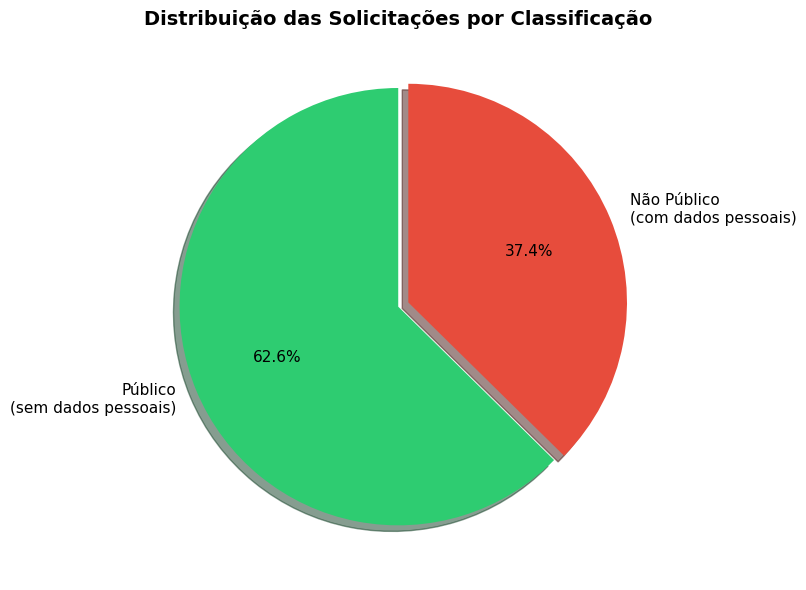


Total de solicitações: 99
Públicas: 62 | Não Públicas: 37


In [8]:
# Gráfico de pizza
valores = df['Classificacao'].value_counts().sort_index()
labels = ['Público\n(sem dados pessoais)', 'Não Público\n(com dados pessoais)']
cores = ['#2ecc71', '#e74c3c']

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    valores, 
    labels=labels, 
    colors=cores, 
    autopct='%1.1f%%', 
    startangle=90,
    explode=(0, 0.05), 
    shadow=True, 
    textprops={'fontsize': 11}
)

ax.set_title('Distribuição das Solicitações por Classificação', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Resumo
print(f"\nTotal de solicitações: {total}")
print(f"Públicas: {publicos} | Não Públicas: {nao_publicos}")

## `Métricas de Avaliação`

As métricas principais do desafio são **Precisão** e **Sensibilidade (Recall)**, combinadas no **F1-Score**.

**Fórmulas:**
- Precisão = VP / (VP + FP)
- Sensibilidade = VP / (VP + FN)
- F1-Score = 2 × (Precisão × Sensibilidade) / (Precisão + Sensibilidade)

In [9]:
# Contagem dos tipos de dados pessoais detectados
print("=== ESTATÍSTICAS DE DETECÇÃO ===\n")

contagem_padroes = {nome: 0 for nome in PADROES_REGEX.keys()}
contagem_padroes['Nome (NLP)'] = 0

for texto in df['Texto Mascarado']:
    padroes = detectar_padroes_regex(texto)
    for tipo in padroes.keys():
        contagem_padroes[tipo] += 1
    
    nomes = detectar_nomes_pessoas(texto)
    if nomes:
        contagem_padroes['Nome (NLP)'] += 1

print("Textos com cada tipo de dado pessoal:")
for tipo, qtd in sorted(contagem_padroes.items(), key=lambda x: x[1], reverse=True):
    if qtd > 0:
        print(f"  - {tipo}: {qtd} ({qtd/total:.1%})")

=== ESTATÍSTICAS DE DETECÇÃO ===

Textos com cada tipo de dado pessoal:
  - Nome (NLP): 28 (28.3%)
  - CPF: 17 (17.2%)
  - Matricula: 12 (12.1%)
  - E-mail: 7 (7.1%)
  - Telefone: 5 (5.1%)
  - CNPJ: 4 (4.0%)
  - OAB: 3 (3.0%)


## `Função da Predição para Submissão`

Função principal para ser utilizada pela CGDF para avaliar o modelo no subconjunto de controle.

In [10]:
def predizer(texto):
    """
    Função principal de predição.
    
    Args:
        texto: String com o texto da solicitação
        
    Returns:
        0 = Público (não contém dados pessoais)
        1 = Não Público (contém dados pessoais)
    """
    return classificar_texto(texto)


def predizer_lote(lista_textos):
    """
    Função para predição em lote.
    
    Args:
        lista_textos: Lista de strings com os textos
        
    Returns:
        Lista de classificações (0 ou 1)
    """
    return [classificar_texto(texto) for texto in lista_textos]


# Teste da função
print("=== TESTE DA FUNÇÃO DE PREDIÇÃO ===\n")

exemplos = [
    "Solicito informações sobre o horário de funcionamento da biblioteca.",
    "Meu nome é João Silva, CPF 123.456.789-00, solicito acesso ao processo.",
    "Gostaria de saber o valor do IPTU para o exercício de 2026.",
    "Eu, Maria Santos, telefone (61) 99999-1234, solicito certidão negativa."
]

for exemplo in exemplos:
    resultado = predizer(exemplo)
    classe = "Não Público" if resultado == 1 else "Público"
    print(f"Texto: {exemplo[:60]}...")
    print(f"Classificação: {classe}\n")

=== TESTE DA FUNÇÃO DE PREDIÇÃO ===

Texto: Solicito informações sobre o horário de funcionamento da bib...
Classificação: Público

Texto: Meu nome é João Silva, CPF 123.456.789-00, solicito acesso a...
Classificação: Não Público

Texto: Gostaria de saber o valor do IPTU para o exercício de 2026....
Classificação: Público

Texto: Eu, Maria Santos, telefone (61) 99999-1234, solicito certidã...
Classificação: Não Público



## `Exportação dos Resultados`

In [11]:
# Criar DataFrame com resultado final
resultado_final = pd.DataFrame({
    'ID': df['ID'],
    'Classificacao': df['Classificacao'],
    'Rotulo': df['Classificacao'].map({0: 'Público', 1: 'Não Público'})
})

# Exibir amostra
print("=== RESULTADO FINAL ===\n")
print(resultado_final.head(10))

# Exportar para CSV
resultado_final.to_csv('resultado_classificacao.csv', index=False, encoding='utf-8-sig')
print(f"\nArquivo 'resultado_classificacao.csv' exportado com sucesso!")
print(f"Total de registros: {len(resultado_final)}")

=== RESULTADO FINAL ===

   ID  Classificacao       Rotulo
0   1              0      Público
1   2              0      Público
2   3              0      Público
3   4              0      Público
4   5              0      Público
5   6              0      Público
6   7              1  Não Público
7   8              1  Não Público
8   9              0      Público
9  10              1  Não Público

Arquivo 'resultado_classificacao.csv' exportado com sucesso!
Total de registros: 99


## `Função para Processar Dataset de Controle`

Função para processar o dataset de controle que será fornecido pela CGDF.

In [13]:
def processar_dataset_controle(caminho_arquivo, coluna_texto='Texto Mascarado', coluna_id='ID'):
    """
    Processa o dataset de controle e retorna as classificações.
    
    Args:
        caminho_arquivo: Caminho para o arquivo (xlsx ou csv)
        coluna_texto: Nome da coluna com os textos
        coluna_id: Nome da coluna com os IDs
        
    Returns:
        DataFrame com ID e Classificação
    """
    # Carregar arquivo
    if caminho_arquivo.endswith('.xlsx'):
        df_controle = pd.read_excel(caminho_arquivo)
    else:
        df_controle = pd.read_csv(caminho_arquivo)
    
    print(f"Dataset carregado: {len(df_controle)} registros")
    
    # Classificar
    resultado = classificar_dataset(df_controle, coluna_texto, coluna_id)
    
    # Estatísticas
    total = len(resultado)
    nao_publicos = resultado['Classificacao'].sum()
    publicos = total - nao_publicos
    
    print(f"\nResultado:")
    print(f"  - Público: {publicos} ({publicos/total:.1%})")
    print(f"  - Não Público: {nao_publicos} ({nao_publicos/total:.1%})")
    
    return resultado


# Exemplo de uso (comentado)
# resultado_controle = processar_dataset_controle('dataset_controle.xlsx')
# resultado_controle.to_csv('resultado_controle.csv', index=False)

print("Função 'processar_dataset_controle' definida e pronta para uso!")

Função 'processar_dataset_controle' definida e pronta para uso!


# ***Resumo da Solução***

### Abordagem Utilizada:
- **Híbrida:** Combinação de Regex (padrões estruturados) + NLP (nomes de pessoas)

### Dados Pessoais Detectados:
| Tipo | Método |
|------|--------|
| CPF | Regex |
| E-mail | Regex |
| Telefone | Regex |
| Matrícula | Regex |
| OAB | Regex |
| CNPJ | Regex |
| Nome de Pessoa | NLP (spaCy) |

### Bibliotecas Utilizadas:
- **pandas:** Manipulação de dados
- **re:** Expressões regulares
- **spacy:** Processamento de linguagem natural
- **matplotlib:** Visualização

### Arquivos Gerados:
- `resultado_classificacao.csv`: Classificação do dataset de amostra

In [14]:
# Resumo final
print("=" * 50)
print("RESUMO DA SOLUÇÃO")
print("=" * 50)
print(f"\nDataset processado: {total} solicitações")
print(f"Classificadas como Público: {publicos} ({publicos/total:.1%})")
print(f"Classificadas como Não Público: {nao_publicos} ({nao_publicos/total:.1%})")
print(f"\nArquivo exportado: resultado_classificacao.csv")
print("=" * 50)

RESUMO DA SOLUÇÃO

Dataset processado: 99 solicitações
Classificadas como Público: 62 (62.6%)
Classificadas como Não Público: 37 (37.4%)

Arquivo exportado: resultado_classificacao.csv
